# Preamble

In [1]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","glue",
              "grid","gridExtra","zoo","RColorBrewer","scales","gganimate",
              "kableExtra","formattable","IRdisplay")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE) }

# to show the plots as svg-graphics in Jupyter
# options(jupyter.plot_mimetypes = "image/svg+xml")
options(jupyter.plot_mimetypes = "image/png") 

if (Sys.info()[['sysname']]=='Windows') {
    windowsFonts(Times = windowsFont("Times New Roman"))
    theme_set(theme_bw(base_size=11,base_family='Times')) 
} else { theme_set(theme_bw(base_size=11)) }

'%&%' = function(x,y)paste0(x,y)

# (Fig 1) Epicurve

In [2]:
filename = "data.xlsx"

read_excel(filename, sheet = "Okinawa", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve
colnames(df_epicurve) = c("onset","confirmed")
df_epicurve %<>% mutate(prefecture="Okinawa")

read_excel(filename, sheet = "Aichi", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve_
colnames(df_epicurve_) = c("onset","confirmed")
df_epicurve_ %<>% mutate(prefecture="Aichi")
df_epicurve %<>% rbind(df_epicurve_)

read_excel(filename, sheet = "Tokyo", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve_
colnames(df_epicurve_) = c("onset","confirmed")
df_epicurve_ %<>% mutate(prefecture="Tokyo")
df_epicurve %<>% rbind(df_epicurve_)

read_excel(filename, sheet = "Kanagawa", range = cell_cols("G:H"), col_types = rep("date",2), col_names = TRUE) -> df_epicurve_
colnames(df_epicurve_) = c("onset","confirmed")
df_epicurve_ %<>% mutate(prefecture="Kanagawa")
df_epicurve %<>% rbind(df_epicurve_)

df_epicurve %<>% 
    mutate(onset=as.Date(onset), confirmed=as.Date(confirmed))

df_epicurve %>% tail

onset,confirmed,prefecture
2018-04-29,2018-05-12,Aichi
2018-05-09,2018-05-12,Aichi
2018-05-12,2018-05-13,Aichi
2018-05-12,2018-05-18,Aichi
2018-05-06,2018-05-08,Tokyo
2018-04-19,2018-05-02,Kanagawa


In [3]:
Df_epicurve = data.frame(date=seq(as.Date('2018-03-14'),as.Date('2018-05-27'),by='1 day'))

df_epicurve %>% 
    group_by(prefecture,onset) %>%
    count %>%
    rename(i=n,date=onset) %>%
    ungroup %>%
    mutate(date=as.Date(date)) %>%
    spread(prefecture,i) %>%
    right_join(Df_epicurve,by="date") %>%
    mutate_if(is.numeric, funs(ifelse(is.na(.), 0, .))) -> df_onset

df_epicurve %>% 
    group_by(prefecture,confirmed) %>%
    count %>%
    rename(i=n,date=confirmed) %>%
    ungroup %>%
    mutate(date=as.Date(date)) %>%
    spread(prefecture,i) %>%
    right_join(Df_epicurve,by="date") %>%
    mutate_if(is.numeric, funs(ifelse(is.na(.), 0, .))) -> df_confirmed

df_confirmed %>% head(10)

date,Aichi,Kanagawa,Okinawa,Tokyo
2018-03-14,0,0,0,0
2018-03-15,0,0,0,0
2018-03-16,0,0,0,0
2018-03-17,0,0,0,0
2018-03-18,0,0,0,0
2018-03-19,0,0,0,0
2018-03-20,0,0,1,0
2018-03-21,0,0,0,0
2018-03-22,0,0,0,0
2018-03-23,0,0,0,0


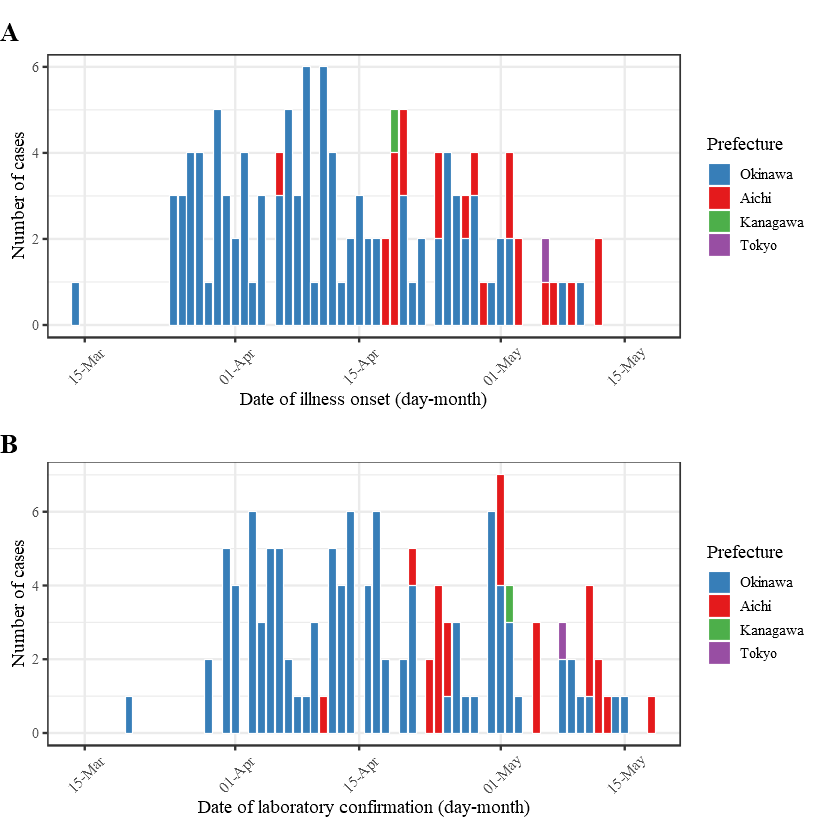

In [4]:
options(repr.plot.width=7,repr.plot.height=7)

cols <- c("Okinawa" = "#377eb8", "Aichi" = "#e41a1c", "Kanagawa" = "#4daf4a", "Tokyo" = "#984ea3")

df_confirmed %>%
    gather(Prefecture,c,-date) %>%
    mutate(Prefecture=factor(Prefecture, levels=c("Okinawa", "Aichi", "Kanagawa", "Tokyo") %>% rev)) %>%
    filter(c>0) %>%
    ggplot(aes(date,c,fill=Prefecture)) +
        geom_bar(stat = "identity",color="white",size=.25) +
        scale_fill_manual(values = cols) +
        coord_cartesian(xlim=c(as.Date("2018-03-14"),as.Date("2018-05-18"))) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(x="Date of laboratory confirmation (day-month)",y="Number of cases") +
        guides(fill = guide_legend(reverse=T)) +
        theme(legend.key.size = unit(.5, "cm"),
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(.5,1,1,.5),"lines")) -> p_confirmed

p_confirmed = arrangeGrob(p_confirmed, top = textGrob("B", x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=16, fontface="bold", fontfamily="Times")))

df_onset %>%
    gather(Prefecture,i,-date) %>%
    mutate(Prefecture=factor(Prefecture, levels=c("Okinawa", "Aichi", "Kanagawa", "Tokyo")%>% rev)) %>%
    filter(i>0) %>%
    ggplot(aes(date,i,fill=Prefecture)) +
        geom_bar(stat = "identity",color="white",size=.25) +
        scale_fill_manual(values = cols) +
        coord_cartesian(xlim=c(as.Date("2018-03-14"),as.Date("2018-05-18"))) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(x="Date of illness onset (day-month)",y="Number of cases") +
        guides(fill = guide_legend(reverse=T)) +
        theme(legend.key.size = unit(.5, "cm"),
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(1,1,.5,.5),"lines")) -> p_onset

p_onset = arrangeGrob(p_onset, top = textGrob("A", x = unit(0, "npc"), y = unit(.25, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=16, fontface="bold", fontfamily="Times")))

grid.arrange(p_onset, p_confirmed, widths=c(1), heights=c(1,1), nrow=2, ncol=1)

# Delay function is assumed to be constant 

For exploration of the case of a time-varying delay, please see another accompanying notebook. 

In [5]:
df_epicurve %>% 
    select(-prefecture) -> df_delay

df_delay %>% head

onset,confirmed
2018-03-14,2018-03-20
2018-03-27,2018-03-29
2018-03-27,2018-03-29
2018-03-26,2018-03-31
2018-03-25,2018-03-31
2018-03-27,2018-03-31


In [6]:
# we shift the onset data of the index case to the date of first exposure 
df_delay[which(df_delay$onset=='2018-03-14'),'onset'] = as.Date('2018-03-17')

df_delay %<>%
    mutate(difference=confirmed-onset,
           # if the onset date is unknown, it is assummed to be 5 days prior the confirmation
           difference=ifelse(is.na(onset),5,difference), 
           onset=if_else(is.na(as.numeric(onset)),confirmed-difference,onset)) %>%
    mutate(onset = as.Date(onset)) %>%
    na.omit

df_delay %>% head

onset,confirmed,difference
2018-03-17,2018-03-20,3
2018-03-27,2018-03-29,2
2018-03-27,2018-03-29,2
2018-03-26,2018-03-31,5
2018-03-25,2018-03-31,6
2018-03-27,2018-03-31,4


Delay distribution function

In [7]:
h = function(t,parms) {
    pweibull(t,parms[1],parms[2])-pweibull(t-1,parms[1],parms[2]) }

# Cumulative distribution function for delay distribution
H = function(t,parms) { pweibull(t,parms[1],parms[2]) }

# Main analysis 

## Loading the data

In [8]:
filename = "data.xlsx"

options(warn=-1)
read_excel(filename, sheet = "raw_onset") %>% ncol -> nclmns
read_excel(filename, sheet = "raw_onset", col_types = rep("date",nclmns)) %>%
    gather(epicurve,onset) %>% 
    mutate(number=1:n()) -> df
if (read_excel(filename, sheet = "raw_confirm") %>% ncol!=nclmns)
    message("Something wrong with number of columns in Excel file!")
read_excel(filename, sheet = "raw_confirm", col_types = rep("date",nclmns)) %>%
    gather(epicurve,confirmed) %>%
    mutate(number=1:n()) %>%
    left_join(df) %>%
    select(epicurve,onset,confirmed) %>%
    mutate(onset=as.Date(onset), confirmed=as.Date(confirmed)) -> df
options(warn=0)
df %>% tail

Joining, by = c("epicurve", "number")


epicurve,onset,confirmed
May27,2018-04-29,2018-05-12
May27,2018-05-09,2018-05-12
May27,2018-05-12,2018-05-13
May27,2018-05-08,2018-05-14
May27,2018-05-10,2018-05-15
May27,2018-05-12,2018-05-18


In [9]:
df %<>%
    mutate(difference=confirmed-onset,
           # if the onset date is unknown, it is assummed to be 5 days prior the confirmation
           difference=ifelse(is.na(onset),5,difference), 
           onset=if_else(is.na(as.numeric(onset)),confirmed-difference,onset)) %>%
    na.omit

# we shift the onset data of the index case to the date of first exposure 
df[which(df$onset=='2018-03-14'),'onset'] = as.Date('2018-03-17')

df %>% head

epicurve,onset,confirmed,difference
Apr01,2018-03-17,2018-03-20,6
Apr01,2018-03-27,2018-03-29,2
Apr01,2018-03-27,2018-03-29,2
Apr01,2018-03-25,2018-03-31,6
Apr01,2018-03-25,2018-03-31,6
Apr01,2018-03-26,2018-03-31,5


In [10]:
# total number of records
df %>% nrow

[1] 2066

We use Gamma distribution to define generation time distribution $g_t$, Weibull distribution for delay distribution $h_t$ between symptoms onset and lab confirmation

In [11]:
# Gamma distribution for incubation period
g = function(time) { 
    g_mean = 11.7; g_var = 9.0 # from (Klinkenberg and Nishiura 2011)
    scl = g_var/g_mean
    pgamma(time,shape=g_mean/scl,scale=scl)-pgamma(time-1,shape=g_mean/scl,scale=scl) }

In [12]:
# using days since index case instead of dates
(mindate = min(df$onset))
(maxdate = max(df$confirmed))
df %<>% 
    mutate(day_onset = unclass(onset)-unclass(mindate),
           day_confirmation = unclass(confirmed)-unclass(mindate))
df %>% head

[1] "2018-03-17"

[1] "2018-05-18"

epicurve,onset,confirmed,difference,day_onset,day_confirmation
Apr01,2018-03-17,2018-03-20,6,0,3
Apr01,2018-03-27,2018-03-29,2,10,12
Apr01,2018-03-27,2018-03-29,2,10,12
Apr01,2018-03-25,2018-03-31,6,8,14
Apr01,2018-03-25,2018-03-31,6,8,14
Apr01,2018-03-26,2018-03-31,5,9,14


In [13]:
# Available epicurves
(all_epicurves = unique(df$epicurve))
# we restrict ourselves to the following epicurves 
# starting from the first one with the time step of eight days
(all_epicurves = c("Apr01","Apr09","Apr17","Apr25","May03","May11","May17","May25"))
df = filter(df,epicurve %in% all_epicurves)

[1] "Apr01" "Apr05" "Apr09" "Apr13" "Apr17" "Apr21" "Apr25" "Apr29" "May01"
[10] "May03" "May05" "May07" "May09" "May11" "May13" "May15" "May17" "May19"
[19] "May21" "May23" "May25" "May27"

[1] "Apr01" "Apr09" "Apr17" "Apr25" "May03" "May11" "May17" "May25"

# As an example, we analyse first only one particular epicurve

In [14]:
(current_epicurve = all_epicurves %>% rev %>% .[5])

[1] "Apr25"

In [15]:
(maxDay = max(df$day_confirmation)+21)

[1] 83

In [16]:
df %>% 
    filter(epicurve==current_epicurve) %>% 
    select(-epicurve) -> df_current

Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

df_current %>% 
    filter(day_onset>0) %>% #removing index case from fitting
    group_by(day_onset) %>%
    count %>%
    rename(day=day_onset) %>%
    right_join(Df,by="day") %>%
    mutate(n=ifelse(is.na(n),0,n)) %>%
    rename(i=n) -> Df

df_current %>%
    filter(day_onset>0) %>% #removing index case from fitting
    group_by(day_confirmation) %>%
    count %>%
    rename(day=day_confirmation) %>%
    right_join(Df,by="day") %>%
    mutate(n=ifelse(is.na(n),0,n)) %>%
    rename(c=n) %>%
    select(day,i,c) %>%
    arrange(day) -> Df

Df %>% tail

day,i,c
34,3,2
35,0,5
36,0,0
37,0,2
38,1,4
39,0,3


In [17]:
# if the parameter "prediction" is FALSE, the result of the function is log-likelihood,
# otherwise it give the resulting data.frame with all entities
calculate_six_generations = function(prms,prediction=FALSE,ndays=maxDay) {
    K = prms[3]; R2 = prms[4]; R3 = prms[5]; R4 = prms[6]; R5 = prms[7]
    
    data.frame(day = 0:ndays) %>%
        mutate(gt=g(day),ht=h(day,prms[1:2])) -> df_

    #calculating first convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv1_gt=conv))
    
    #calculating second convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv1_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv2_gt=conv))
    
    #calculating third convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv2_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv3_gt=conv))
    
    #calculating fourth convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv3_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv4_gt=conv))


    df_ %<>% 
        mutate(ft = (gt+R2*conv1_gt+R2*R3*conv2_gt+R2*R3*R4*conv3_gt+R2*R3*R4*R5*conv3_gt)/(1+R2+R2*R3+R2*R3*R4+R2*R3*R4*R5)) 
    
    #calculating convolution with h
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$ft[1:x]*df_$ht[x:1])) }
    df_ %<>% do(cbind(.,conv_ht=conv)) 
    
    if (prediction) {
        df_ %>% 
            left_join(Df,by="day") %>%
            mutate(lambda_i = K*ft, lambda_c = K*conv_ht) %>%
            left_join(select(Df,-i,-c),by="day") %>% return
        
    } else {
        df_ %<>% right_join(Df,by="day")
        
        maxday = max(df_$day)
        
        df_ %>%
            filter(ft>0 & day<maxday) %>% 
            summarize(loglk = sum(i*log(H(maxday-day,prms[1:2])*K*ft)-H(maxday-day,prms[1:2])*K*ft-lfactorial(i))) %>% 
            .$loglk -> loglk_onset
        
        df_current %>% 
            group_by(difference) %>%
            count %>%
            ungroup %>%
            summarize(loglk = sum(n*log(h(difference,prms[1:2])))) %>% 
            .$loglk -> loglk_delay
    
        return(loglk_delay+loglk_onset)
    }
}

calculate_five_generations = function(x,prediction=FALSE,ndays=maxDay) { calculate_six_generations(c(x[1:6],0),prediction,ndays) }

calculate_four_generations = function(x,prediction=FALSE,ndays=maxDay) { calculate_six_generations(c(x[1:5],0,0),prediction,ndays) }

calculate_three_generations = function(x,prediction=FALSE,ndays=maxDay) { calculate_six_generations(c(x[1:4],0,0,0),prediction,ndays) }

calculate_two_generations = function(x,prediction=FALSE,ndays=maxDay) { calculate_six_generations(c(x[1:3],0,0,0,0),prediction,ndays) }

getDelay = function(prms) {
    df_current %>% 
        mutate(delta = day_confirmation-day_onset) %>%
        group_by(delta) %>%
        count %>%
        ungroup -> df_

    df_ %>% 
        right_join(data.frame(delta=1:max(df_$delta)+1),by="delta") %>%
        mutate(n = ifelse(is.na(n),0,n), ht = h(delta,prms)) %>%
        mutate(freq = n/sum(n)) %>%
        return
}

In [18]:
# test
init = c(2,4,100,1.2)
calculate_three_generations(init)

[1] -234.3603

In [19]:
# Assume we have only three generations
pars = c(2,4,100,1.2)

options(warn=-1)
sol = optim(pars,function(x) calculate_three_generations(x,FALSE,nrow(Df)),
            method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,4),
            hessian=TRUE)
options(warn=0)
pars = sol$par 

sol

-20.601380378,7.635957783,-0.002205017,-0.035936345
7.635957783,-26.208175811,0.005473566,0.089214208
-0.002205017,0.005473566,-0.012088051,0.002088647
-0.035936345,0.089214208,0.002088647,-5.014634496


In [20]:
# Obtained Weibull distribution mean and variance
c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))

[1] 3.969957 2.944459

In [21]:
calculate_three_generations(pars,prediction=TRUE,ndays=maxDay) -> dfMLE 
dfMLE %>% tail(10)

,day,gt,ht,conv1_gt,conv2_gt,conv3_gt,conv4_gt,ft,conv_ht,i,c,lambda_i,lambda_c
75,74,0,0,3.420300e-15,7.139891e-09,6.381711e-05,0.0095319312,2.197041e-15,4.024195e-13,NA,NA,1.798468e-13,3.294151e-11
76,75,0,0,1.391898e-15,3.591380e-09,3.977577e-05,0.0073791205,8.940899e-16,1.715407e-13,NA,NA,7.318898e-14,1.404209e-11
77,76,0,0,5.633177e-16,1.791567e-09,2.451426e-05,0.0056317491,3.618489e-16,7.264719e-14,NA,NA,2.962046e-14,5.946800e-12
78,77,0,0,2.267441e-16,8.865478e-10,1.494404e-05,0.0042389912,1.456498e-16,3.057120e-14,NA,NA,1.192269e-14,2.502517e-12
79,78,0,0,9.077752e-17,4.352722e-10,9.013465e-06,0.0031479024,5.831123e-17,1.278565e-14,NA,NA,4.773278e-15,1.046616e-12
80,79,0,0,3.614878e-17,2.120791e-10,5.380346e-06,0.0023071314,2.322028e-17,5.315207e-15,NA,NA,1.900781e-15,4.350957e-13
81,80,0,0,1.431809e-17,1.025647e-10,3.179356e-06,0.0016694088,9.197272e-18,2.196693e-15,NA,NA,7.528762e-16,1.798183e-13
82,81,0,0,5.640885e-18,4.924284e-11,1.860330e-06,0.0011929816,3.623440e-18,9.026705e-16,NA,NA,2.966099e-16,7.389138e-14
83,82,0,0,2.210376e-18,2.347535e-11,1.078127e-06,0.0008422123,1.419842e-18,3.688523e-16,NA,NA,1.162263e-16,3.019375e-14
84,83,0,0,8.614324e-19,1.111426e-11,6.189882e-07,0.0005875667,5.533438e-19,1.498940e-16,NA,NA,4.529597e-17,1.227012e-14


Warning message:
"Removed 44 rows containing missing values (geom_bar)."Warning message:
"Removed 44 rows containing missing values (geom_bar)."

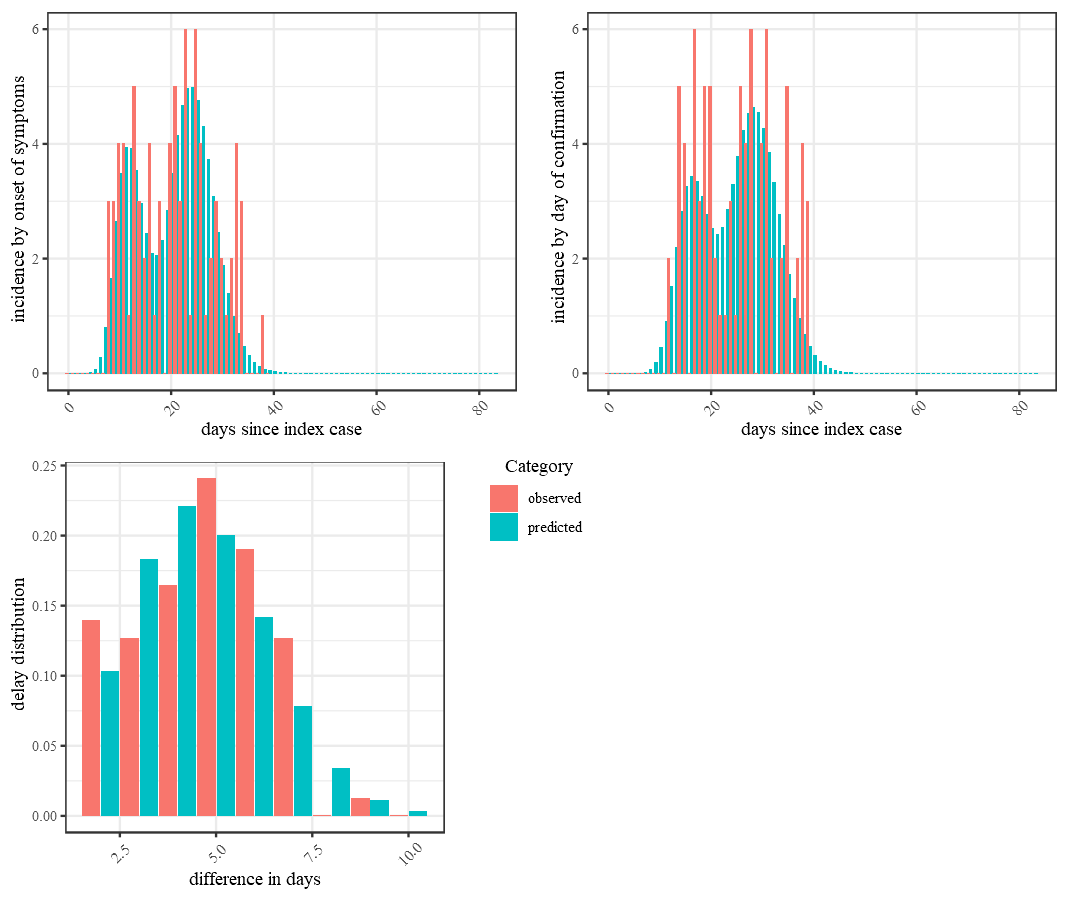

In [22]:
options(repr.plot.width=9,repr.plot.height=7.5)
xmax = max(dfMLE$day)

dfMLE %>%
    select(one_of("day","lambda_i","i")) %>%
    rename(pred=lambda_i,obs=i) %>%
    gather(Category,Count,-day) %>%
    mutate(Category=factor(Category,levels=c("pred","obs") %>% rev)) %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        coord_cartesian(xlim=c(0,xmax)) +
        guides(fill=F) +
        labs(y="incidence by onset of symptoms",x="days since index case") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_onset

dfMLE %>%
    select(one_of("day","lambda_c","c")) %>%
    rename(pred=lambda_c,obs=c) %>%
    gather(Category,Count,-day) %>%
    mutate(Category=factor(Category,levels=c("pred","obs") %>% rev)) %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        coord_cartesian(xlim=c(0,xmax)) +
        guides(fill=F) +
        labs(y="incidence by day of confirmation",x="days since index case") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_confirmation

getDelay(pars[1:2]) %>%
    select(delta,ht,freq) %>%
    rename(predicted=ht,observed=freq) %>%
    gather(Category,Count,-delta) %>%
    mutate(Category=factor(Category,levels=c("predicted","observed") %>% rev)) %>%
    ggplot(aes(x=delta)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        guides(fill=guide_legend(title.hjust = 0.5)) +
        labs(y="delay distribution",x="difference in days") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(1.25,.9),
              plot.margin = unit(c(.5,4,.5,.5),"lines")
             ) -> plt_delay

grid.arrange(ggplotGrob(plt_onset), ggplotGrob(plt_confirmation), ggplotGrob(plt_delay),
                 widths=c(1,1), heights=c(1,1), nrow=2, ncol=2)

## Constructing confidence intervals

Note that all parameters are sqrts of the real parameters

In [23]:
(vc = solve(-sol$hessian))
(sd = sqrt(diag(vc)))

0.0544172282,0.0158539376,-0.00276646,-0.0001090684
0.0158539376,0.0427808944,0.01659264,0.0006544021
-0.0027664604,0.0165926403,82.74034592,0.0347772366
-0.0001090684,0.0006544021,0.03477724,0.1994432375


[1] 0.2332750 0.2068354 9.0961720 0.4465907

In [24]:
# sampling
sample = 1e3
hess_sam = MASS::mvrnorm(n=sample, mu=sol$par, 
                     Sigma=solve(-sol$hessian),
                     tol=1e-06, empirical=FALSE, EISPACK=FALSE)
hess_sam %>% as.data.frame -> df_hess

colnames(df_hess) = c("h1","h2","K","R2")
df_hess %>% head

h1,h2,K,R2
2.412984,4.388550,88.14053,2.742298
2.299917,4.422654,94.60466,2.177294
2.420593,4.798912,88.23851,2.128072
2.880478,4.848751,90.76846,1.901418
2.730392,4.462342,81.04483,2.303271
2.505417,4.329426,84.42063,1.911473


In [25]:
# selecting 95% middle range
data.frame(
    h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
    h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
    K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
    R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2
) -> df_perturb

df_perturb[df_perturb<0] = 0

df_perturb %>% head

h1,h2,K,R2
2.412984,4.388550,88.14053,2.177294
2.299917,4.422654,94.60466,2.128072
2.420593,4.798912,88.23851,1.901418
2.880478,4.848751,90.76846,2.303271
2.730392,4.462342,81.04483,1.911473
2.505417,4.329426,84.42063,1.989761


In [26]:
# prediction
res = NULL
for (i in 1:nrow(df_perturb)) {
    res = rbind(res,calculate_three_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                select(day,contains("lambda"))) }

In [27]:
res %>% 
    group_by(day) %>%
    summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
              c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

Warning message:
"Removed 44 rows containing missing values (geom_bar)."Warning message:
"Removed 44 rows containing missing values (geom_bar)."

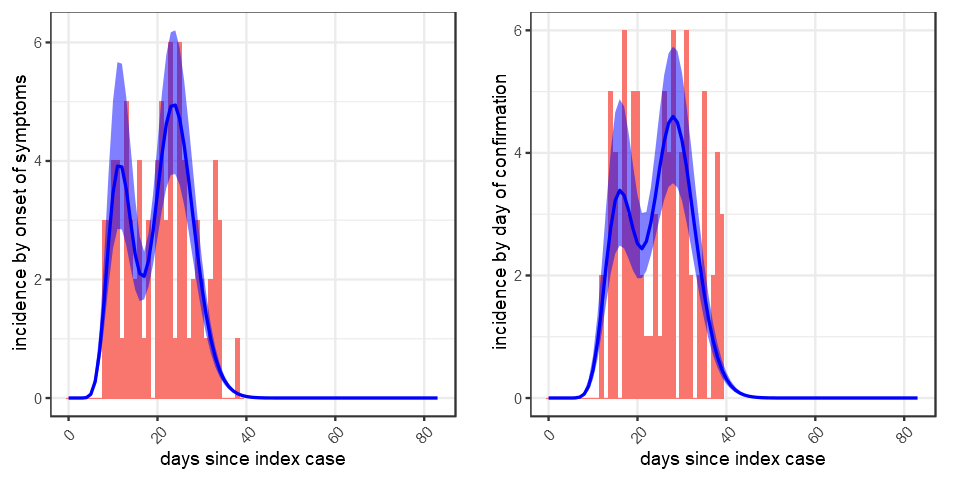

In [28]:
options(repr.plot.width=8,repr.plot.height=4)
xmax = max(dfMLE$day)

dfMLE %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=i,fill="red"),stat="identity",position=position_dodge(1)) +
        geom_ribbon(data=result,aes(ymin=c025_i,ymax=c975_i),fill="blue",alpha=.5) +
        geom_line(data=result,aes(y=median_i),size=.7,color="blue") +
        coord_cartesian(xlim=c(0,maxDay)) +
        guides(fill=F) +
        labs(y="incidence by onset of symptoms", x="days since index case") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_onset

dfMLE %>%
    ggplot(aes(x=day,fill="red")) +
        geom_bar(aes(y=c),stat="identity",position=position_dodge(1)) +
        geom_ribbon(data=result,aes(ymin=c025_c,ymax=c975_c),fill="blue",alpha=.5) +
        geom_line(data=result,aes(y=median_c),size=.7,color="blue") +
        coord_cartesian(xlim=c(0,maxDay)) +
        guides(fill=F) +
        labs(y="incidence by day of confirmation",x="days since index case") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_confirmation

p = grid.arrange(ggplotGrob(plt_onset), ggplotGrob(plt_confirmation), 
                 widths=c(1,1), heights=c(1), nrow=1, ncol=2)

# Generating a table with varied number of generations

## Two generations

In [29]:
nsmpl = 1e3

final_two_generations = NULL
pars_final_two_generations = NULL
# initial parameter values used in optim function
pars = c(5,4,30)
options(warn=-1)
for (current_epicurve in unique(df$epicurve)) { 
    message(current_epicurve)
    
    df %>% 
        filter(epicurve==current_epicurve) %>% 
        select(-epicurve) -> df_current

    Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df

    sol = optim(c(pars[1:2],pars[3]+10),calculate_two_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_two_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_two_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","loglk","AIC","rmse_i","rmse_c")

    print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                                 df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_two_generations) -> pars_final_two_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_two_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                        select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_two_generations) -> final_two_generations},
    error=function(cond){print(cond)})
}
options(warn=0) 

Apr01


    mean_h   var_h   par1_h   par2_h        K     loglk      AIC   rmse_i
1 4.044729 3.93481 2.147092 4.567165 28.42619 -37.19753 80.39506 1.665254
     rmse_c
1 0.8761112


Apr09


    mean_h    var_h   par1_h   par2_h       K     loglk      AIC   rmse_i
1 3.912038 3.872446 2.087287 4.416723 35.3252 -100.4916 206.9832 1.085741
    rmse_c
1 1.375038


Apr17


   mean_h   var_h   par1_h   par2_h       K    loglk    AIC   rmse_i   rmse_c
1 3.92412 2.91365 2.454593 4.424606 63.0124 -273.625 553.25 2.808329 2.719264


Apr25


   mean_h   var_h   par1_h   par2_h        K     loglk      AIC   rmse_i
1 3.95583 2.91829 2.474558 4.459547 80.99987 -483.1372 972.2744 3.343216
    rmse_c
1 3.175626


May03


    mean_h    var_h   par1_h   par2_h        K     loglk      AIC   rmse_i
1 4.181956 4.216275 2.144271 4.722104 103.9999 -902.1055 1810.211 4.088817
    rmse_c
1 3.783279


May11


    mean_h   var_h   par1_h   par2_h        K     loglk      AIC   rmse_i
1 4.411256 5.55761 1.951456 4.974953 117.0001 -1234.551 2475.101 4.316133
    rmse_c
1 3.843505


May17


    mean_h    var_h   par1_h   par2_h   K   loglk    AIC   rmse_i   rmse_c
1 4.481232 6.066929 1.891583 5.049322 121 -1353.2 2712.4 4.241854 3.736616


May25


    mean_h    var_h   par1_h   par2_h   K     loglk      AIC   rmse_i  rmse_c
1 4.505738 6.104282 1.896587 5.077376 121 -1354.903 2715.805 3.997477 3.51448


## Three generations

In [30]:
final_three_generations = NULL
pars_final_three_generations = NULL
pars = c(2,4,50,1)
options(warn=-1)
for (current_epicurve in unique(df$epicurve)) { 
    message(current_epicurve)
    # initial parameter values used in optim function
    
    df %>% 
        filter(epicurve==current_epicurve) %>% 
        select(-epicurve) -> df_current

    Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df
    

    sol = optim(c(pars[1:2],pars[3]+5,pars[4]),calculate_three_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_three_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_three_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","loglk","AIC","rmse_i","rmse_c")

    print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                         df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_three_generations) -> pars_final_three_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_three_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                        select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_three_generations) -> final_three_generations},
    error=function(cond){print(cond)})
}
options(warn=0) 

Apr01


    mean_h    var_h   par1_h  par2_h        K       R2     loglk      AIC
1 4.043375 3.929088 2.148032 4.56564 55.00361 0.942021 -37.18387 82.36774
    rmse_i    rmse_c
1 1.678754 0.8764463


Apr09


    mean_h    var_h   par1_h   par2_h        K       R2     loglk      AIC
1 4.061809 3.803687 2.198327 4.586387 68.10914 1.206308 -98.06433 204.1287
    rmse_i   rmse_c
1 1.575942 1.365755


Apr17


  mean_h    var_h   par1_h   par2_h        K       R2     loglk      AIC
1 4.0686 3.037541 2.497002 4.585693 75.93085 1.562446 -168.2095 344.4191
    rmse_i   rmse_c
1 1.423323 1.574114


Apr25


   mean_h    var_h   par1_h  par2_h        K       R2     loglk      AIC
1 3.96996 2.944498 2.472058 4.47558 81.85764 1.796067 -227.8017 463.6033
    rmse_i   rmse_c
1 1.395616 1.759488


May03


    mean_h    var_h   par1_h   par2_h        K       R2     loglk      AIC
1 4.182729 4.219104 2.143912 4.722976 104.0288 2.680026 -367.6309 743.2619
    rmse_i   rmse_c
1 2.092078 2.423855


May11


    mean_h    var_h   par1_h   par2_h        K       R2     loglk      AIC
1 4.411276 5.557732 1.951442 4.974974 117.0004 3.206211 -503.2963 1014.593
   rmse_i   rmse_c
1 2.38226 2.577793


May17


    mean_h    var_h   par1_h   par2_h        K       R2     loglk      AIC
1 4.468838 6.048349 1.888994 5.035126 122.0004 3.410735 -569.8415 1147.683
    rmse_i  rmse_c
1 2.390018 2.55106


May25


    mean_h    var_h   par1_h   par2_h        K       R2     loglk      AIC
1 4.505307 6.100825 1.896981 5.076924 122.9987 3.451793 -585.4792 1178.958
    rmse_i   rmse_c
1 2.279852 2.419238


## Four generations

In [31]:
final_four_generations = NULL
pars_final_four_generations = NULL
pars = c(2,4,50,1,.5) # initial parameter values used in optim function
options(warn=-1)
for (current_epicurve in rev(unique(df$epicurve))) { 
    message(current_epicurve)
    
    df %>% 
        filter(epicurve==current_epicurve) %>% 
        select(-epicurve) -> df_current

    Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df
    

    sol = optim(c(pars[1:2],pars[3]+10,pars[4:5]),calculate_four_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,3),hessian=TRUE)
    pars = sol$par
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_four_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_four_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","R3","loglk","AIC","rmse_i","rmse_c")

    print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2","R3")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2,
            R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                         df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","R3_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","R3_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_four_generations) -> pars_final_four_generations
        
        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_four_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                            select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_four_generations) -> final_four_generations}, 
    error=function(cond){print(cond)})
}
options(warn=0)

May25


    mean_h    var_h   par1_h   par2_h        K       R2       R3     loglk
1 4.505385 6.100896 1.897005 5.077014 123.0019 1.231521 1.492512 -385.3901
       AIC   rmse_i   rmse_c
1 780.7802 1.362435 1.737148


May17


    mean_h    var_h   par1_h   par2_h       K       R2       R3     loglk
1 4.470651 6.056689 1.888401 5.037115 122.036 1.235419 1.459959 -379.2837
       AIC   rmse_i  rmse_c
1 768.5674 1.421695 1.83589


May11


    mean_h    var_h   par1_h   par2_h        K       R2       R3     loglk
1 4.424447 5.602962 1.949123 4.989681 117.5911 1.255956 1.306539 -353.1258
       AIC   rmse_i  rmse_c
1 716.2517 1.450414 1.87779


May03


    mean_h    var_h   par1_h   par2_h        K       R2       R3     loglk
1 4.244364 4.325074 2.149232 4.792594 109.5891 1.298885 1.033695 -294.6049
       AIC  rmse_i   rmse_c
1 599.2098 1.36427 1.837281


Apr25


    mean_h   var_h   par1_h   par2_h        K       R2        R3     loglk
1 4.038411 2.96489 2.510024 4.551081 98.94443 1.341174 0.7126048 -219.0389
       AIC  rmse_i   rmse_c
1 448.0779 1.42144 1.607982


Apr17


    mean_h    var_h  par1_h  par2_h        K       R2 R3     loglk      AIC
1 4.068598 3.037498 2.49702 4.58569 75.93068 1.562429  0 -168.2095 346.4191
    rmse_i   rmse_c
1 1.423319 1.574113


Apr09


    mean_h    var_h   par1_h   par2_h       K      R2        R3     loglk
1 4.062064 3.803468 2.198552 4.586675 85.9197 1.20725 0.4770969 -98.06528
       AIC  rmse_i   rmse_c
1 206.1306 1.58002 1.365827


Apr01


    mean_h    var_h   par1_h   par2_h        K       R2 R3     loglk      AIC
1 4.043177 3.921509 2.150226 4.565423 95.93348 2.396707  0 -37.16367 84.32734
    rmse_i   rmse_c
1 1.705506 0.876105
<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


## Five generations

In [32]:
final_five_generations = NULL
pars_final_five_generations = NULL
# initial parameter values used in optim function
pars = c(2,4,50,1,.5,.5)
options(warn=-1)
for (current_epicurve in rev(unique(df$epicurve))[1:5]) { 
    message(current_epicurve)
    
    df %>% 
        filter(epicurve==current_epicurve) %>% 
        select(-epicurve) -> df_current

    Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df
    

    sol = optim(c(pars[1:2],pars[3]+10,pars[4:6]),calculate_five_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par 
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_five_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_five_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","R3","R4","loglk","AIC","rmse_i","rmse_c")

    print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2","R3","R4")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2,
            R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3,
            R4=filter(df_hess,R4 > quantile(R4, 0.025) & R4 < quantile(R4, 0.975))$R4
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                 df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","R3_CIlower","R4_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","R3_CIupper","R4_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_five_generations) -> pars_final_five_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_five_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                            select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_five_generations) -> final_five_generations},
    error=function(cond){print(cond)})
}
options(warn=0)

May25


    mean_h    var_h  par1_h   par2_h        K       R2        R3        R4
1 4.510033 6.117942 1.89624 5.082185 123.2087 1.320717 0.9124833 0.4764253
      loglk      AIC   rmse_i   rmse_c
1 -368.9547 749.9095 1.204524 1.608375


May17


    mean_h    var_h   par1_h   par2_h        K       R2        R3        R4
1 4.500801 6.134764 1.889065 5.071145 124.3386 1.325099 0.8917298 0.5351187
      loglk      AIC  rmse_i   rmse_c
1 -364.4321 740.8643 1.26653 1.702766


May11


    mean_h    var_h   par1_h   par2_h        K      R2        R3        R4
1 4.480769 5.690116 1.959821 5.053868 125.5775 1.33297 0.8529986 0.6264135
      loglk      AIC   rmse_i   rmse_c
1 -345.5786 703.1571 1.372707 1.777549


May03


    mean_h   var_h   par1_h   par2_h        K       R2        R3       R4
1 4.293687 4.32566 2.176918 4.848307 142.1119 1.351254 0.7622644 1.317261
      loglk      AIC   rmse_i   rmse_c
1 -293.3547 598.7095 1.572422 1.771923


Apr25


    mean_h    var_h   par1_h   par2_h        K      R2        R3       R4
1 4.040469 2.957629 2.514895 4.553177 152.0903 1.35062 0.6565181 2.078147
     loglk      AIC   rmse_i  rmse_c
1 -218.909 449.8179 1.487563 1.60544


## Six generations

In [33]:
final_six_generations = NULL
pars_final_six_generations = NULL
pars = c(2,4,50,1,.5,.5,.25)
options(warn=-1)
for (current_epicurve in rev(unique(df$epicurve))[1:5]) { 
    message(current_epicurve)
    
    df %>% 
        filter(epicurve==current_epicurve) %>% 
        select(-epicurve) -> df_current

    Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df

    sol = optim(c(pars[1:2],pars[3]+10,pars[4:7]),calculate_six_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par 
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_six_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_six_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","R3","R4","R5","loglk","AIC","rmse_i","rmse_c")

    print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2","R3","R4","R5")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2,
            R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3,
            R4=filter(df_hess,R4 > quantile(R4, 0.025) & R4 < quantile(R4, 0.975))$R4,
            R5=filter(df_hess,R5 > quantile(R5, 0.025) & R5 < quantile(R5, 0.975))$R5
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
             df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","R3_CIlower","R4_CIlower","R5_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","R3_CIupper","R4_CIupper","R5_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_six_generations) -> pars_final_six_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_six_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                            select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_six_generations) -> final_six_generations},
    error=function(cond){print(cond)})
}
options(warn=0)

May25


    mean_h   var_h   par1_h   par2_h        K       R2        R3        R4
1 4.509962 6.11754 1.896276 5.082108 123.2098 1.320998 0.9123912 0.3351625
         R5     loglk      AIC   rmse_i   rmse_c
1 0.4215619 -368.9547 751.9095 1.204519 1.608389


May17


    mean_h    var_h   par1_h   par2_h        K       R2        R3        R4
1 4.500689 6.133833 1.889172 5.071029 124.3417 1.325124 0.8917507 0.3813006
         R5     loglk      AIC   rmse_i   rmse_c
1 0.4033538 -364.4321 742.8643 1.266531 1.702765


May11


   mean_h    var_h   par1_h   par2_h        K       R2        R3        R4
1 4.48078 5.690438 1.959765 5.053877 125.5748 1.332983 0.8531439 0.4551575
         R5     loglk      AIC   rmse_i  rmse_c
1 0.3761764 -345.5786 705.1571 1.372709 1.77756
<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


May03


    mean_h    var_h  par1_h   par2_h       K       R2        R3       R4
1 4.293689 4.325764 2.17689 4.848309 142.095 1.351341 0.7623126 0.862254
         R5     loglk      AIC   rmse_i   rmse_c
1 0.5270132 -293.3547 600.7095 1.572263 1.771947


Apr25


    mean_h    var_h   par1_h   par2_h        K      R2        R3       R4
1 4.040527 2.957701 2.514901 4.553243 152.0894 1.35066 0.6565404 1.200561
         R5    loglk      AIC   rmse_i   rmse_c
1 0.7309249 -218.909 451.8179 1.487571 1.605442


## Aggregation of the results

In [34]:
rbind(
    final_two_generations %>% mutate(generations=2),
    final_three_generations %>% mutate(generations=3),
    final_four_generations %>% mutate(generations=4),
    final_five_generations %>% mutate(generations=5),
    final_six_generations %>% mutate(generations=6)) %>%
select(generations,everything()) -> final

final %>% head

generations,day,c025_i,median_i,c975_i,c025_c,median_c,c975_c,epicurve,i,c,MLE_i,MLE_c
2,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,May25,0,0,0.000000e+00,0.000000e+00
2,1,7.048828e-10,8.286777e-10,9.569254e-10,0.000000e+00,0.000000e+00,0.000000e+00,May25,0,0,8.323354e-10,0.000000e+00
2,2,7.963221e-06,9.361760e-06,1.081060e-05,2.460082e-11,3.763182e-11,5.641193e-11,May25,0,0,9.403082e-06,3.733066e-11
2,3,1.132356e-03,1.331226e-03,1.537249e-03,2.779970e-07,4.252271e-07,6.374123e-07,May25,0,0,1.337102e-03,4.218264e-07
2,4,2.631172e-02,3.093271e-02,3.571992e-02,4.037793e-05,6.149440e-05,9.191020e-05,May25,0,0,3.106925e-02,6.102488e-05
2,5,2.226063e-01,2.617015e-01,3.022029e-01,1.040708e-03,1.554836e-03,2.290330e-03,May25,0,0,2.628567e-01,1.544922e-03


In [35]:
rbind(
    pars_final_two_generations %>% mutate(generations=2),
    pars_final_three_generations %>% mutate(generations=3),
    pars_final_four_generations %>% mutate(generations=4),
    pars_final_five_generations %>% mutate(generations=5),
    pars_final_six_generations %>% mutate(generations=6)) %>%
select(generations,everything()) -> pars_final

pars_final %>% head

generations,parameter,estimate,epicurve
2,mean_h,4.505738,May25
2,var_h,6.104282,May25
2,par1_h,1.896587,May25
2,par2_h,5.077376,May25
2,K,121.000022,May25
2,loglk,-1354.902665,May25


# Output that is further used to generate Table 1

In [36]:
# raw output
pars_final %<>% 
    spread(parameter,estimate) %>% 
    select(generations,epicurve,mean_h,mean_h_CIlower,mean_h_CIupper,
           var_h,var_h_CIlower,var_h_CIupper,K,K_CIlower,K_CIupper,starts_with("R"),loglk,AIC,rmse_i,rmse_c)

pars_final %>% write.csv(file="pars_final.csv")

pars_final

generations,epicurve,mean_h,mean_h_CIlower,mean_h_CIupper,var_h,var_h_CIlower,var_h_CIupper,K,K_CIlower,...,R4,R4_CIlower,R4_CIupper,R5,R5_CIlower,R5_CIupper,rmse_c,rmse_i,loglk,AIC
2,Apr01,4.044729,3.047817,5.237805,3.934810,1.295805,19.730880,28.42619,10.60133,...,NA,NA,NA,NA,NA,NA,0.8761112,1.665254,-37.19753,80.39506
2,Apr09,3.912038,3.308452,4.654906,3.872446,1.913601,9.861646,35.32520,23.14232,...,NA,NA,NA,NA,NA,NA,1.3750378,1.085741,-100.49162,206.98325
2,Apr17,3.924120,3.510476,4.323322,2.913650,1.891486,4.823307,63.01240,48.56934,...,NA,NA,NA,NA,NA,NA,2.7192636,2.808329,-273.62498,553.24995
2,Apr25,3.955830,3.618954,4.305033,2.918290,1.944458,4.716382,80.99987,63.37236,...,NA,NA,NA,NA,NA,NA,3.1756256,3.343216,-483.13721,972.27441
2,May03,4.181956,3.824818,4.570541,4.216275,2.818678,6.397058,103.99988,83.33127,...,NA,NA,NA,NA,NA,NA,3.7832788,4.088817,-902.10549,1810.21099
2,May11,4.411256,4.000980,4.855401,5.557610,3.821100,8.264751,117.00015,96.85182,...,NA,NA,NA,NA,NA,NA,3.8435051,4.316133,-1234.55070,2475.10140
2,May17,4.481232,4.061954,4.967866,6.066929,4.191562,9.533892,120.99995,100.19952,...,NA,NA,NA,NA,NA,NA,3.7366163,4.241854,-1353.20001,2712.40002
2,May25,4.505738,4.033883,4.950997,6.104282,4.005697,9.242184,121.00002,100.37428,...,NA,NA,NA,NA,NA,NA,3.5144798,3.997477,-1354.90267,2715.80533
3,Apr01,4.043375,3.053632,5.214922,3.929088,1.270452,18.496125,55.00361,0.00000,...,NA,NA,NA,NA,NA,NA,0.8764463,1.678754,-37.18387,82.36774
3,Apr09,4.061809,3.440430,4.725307,3.803687,1.990015,8.543030,68.10914,18.66919,...,NA,NA,NA,NA,NA,NA,1.3657549,1.575942,-98.06433,204.12866


In [37]:
# a bit nicer form
options(warn=-1)
pars_final %>% 
    arrange(epicurve,generations) %>%
    group_by(epicurve) %>%
    mutate(AICmin = ifelse(AIC==min(AIC),TRUE,FALSE),
           `mean of ht`=ifelse(AIC==min(AIC),
                               glue('{sprintf("%0.2f",mean_h)} ({sprintf("%0.2f",mean_h_CIlower)}-{sprintf("%0.2f",mean_h_CIupper)})'),
                               sprintf("%0.2f",mean_h)),
           `variance of ht`=ifelse(AIC==min(AIC),
                                   glue('{sprintf("%0.2f",var_h)} ({sprintf("%0.2f",var_h_CIlower)}-{sprintf("%0.2f",var_h_CIupper)})'),
                                   sprintf("%0.2f",var_h)),
           K=ifelse(AIC==min(AIC),
                    glue('{sprintf("%0.1f",K)} ({sprintf("%0.1f",K_CIlower)}-{sprintf("%0.1f",K_CIupper)})'),
                    sprintf("%0.1f",K)),
           R2=ifelse(!is.na(R2),
                     ifelse(AIC==min(AIC),
                            glue('{sprintf("%0.2f",R2)} ({sprintf("%0.2f",R2_CIlower)}-{sprintf("%0.2f",R2_CIupper)})'),
                            sprintf("%0.2f",R2)),
                     ''),
           R3=ifelse(!is.na(R3),
                     ifelse(AIC==min(AIC),
                            glue('{sprintf("%0.2f",R3)} ({sprintf("%0.2f",R3_CIlower)}-{sprintf("%0.2f",R3_CIupper)})'),
                            sprintf("%0.2f",R3)),
                     ''),
           R4=ifelse(!is.na(R4),
                     ifelse(AIC==min(AIC),
                            glue('{sprintf("%0.2f",R4)} ({sprintf("%0.2f",R4_CIlower)}-{sprintf("%0.2f",R4_CIupper)})'),
                            sprintf("%0.2f",R4)),
                     ''),
           R5=ifelse(!is.na(R5),
                     ifelse(AIC==min(AIC),
                            glue('{sprintf("%0.2f",R5)} ({sprintf("%0.2f",R5_CIlower)}-{sprintf("%0.2f",R5_CIupper)})'),
                            sprintf("%0.2f",R5)),
                     ''),
           negloglk=sprintf("%.1f",-loglk),
           AIC=sprintf("%.1f",AIC),
           rmse_i=sprintf("%.2f",rmse_i),
           rmse_c=sprintf("%.2f",rmse_c)
          ) %>%
    select(epicurve,generations,`mean of ht`,`variance of ht`,K,R2,R3,R4,R5,negloglk,AIC,rmse_i,rmse_c,AICmin) -> pars_final_kabble

pars_final_kabble %>%
    select(-AICmin) %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    row_spec(which(pars_final_kabble$AICmin), bold = T, color = "brown") %>%
    as.character() %>%
    display_html()
options(warn=0)

epicurve,generations,mean of ht,variance of ht,K,R2,R3,R4,R5,negloglk,AIC,rmse_i,rmse_c
Apr01,2,4.04 (3.05-5.24),3.93 (1.30-19.73),28.4 (10.6-46.0),,,,,37.2,80.4,1.67,0.88
Apr01,3,4.04,3.93,55.0,0.94,,,,37.2,82.4,1.68,0.88
Apr09,2,3.91,3.87,35.3,,,,,100.5,207.0,1.09,1.38
Apr09,3,4.06 (3.44-4.73),3.80 (1.99-8.54),68.1 (18.7-116.2),1.21 (0.00-3.01),,,,98.1,204.1,1.58,1.37
Apr09,4,4.06,3.80,85.9,1.21,0.48,,,98.1,206.1,1.58,1.37
Apr17,2,3.92,2.91,63.0,,,,,273.6,553.2,2.81,2.72
Apr17,3,4.07 (3.61-4.50),3.04 (1.89-5.36),75.9 (55.7-95.5),1.56 (0.71-2.44),,,,168.2,344.4,1.42,1.57
Apr17,4,4.07,3.04,75.9,1.56,0.00,,,168.2,346.4,1.42,1.57
Apr25,2,3.96,2.92,81.0,,,,,483.1,972.3,3.34,3.18
Apr25,3,3.97,2.94,81.9,1.80,,,,227.8,463.6,1.40,1.76


## Selecting the ones with minimal AIC

In [47]:
pars_final %>%
    group_by(epicurve) %>%
    filter(AIC==min(AIC)) %>%
    ungroup -> pars_final_minAIC

pars_final_minAIC

generations,epicurve,mean_h,mean_h_CIlower,mean_h_CIupper,var_h,var_h_CIlower,var_h_CIupper,K,K_CIlower,...,R4,R4_CIlower,R4_CIupper,R5,R5_CIlower,R5_CIupper,rmse_c,rmse_i,loglk,AIC
2,Apr01,4.044729,2.965966,5.430933,3.934810,1.166348,20.957400,28.42619,9.875538,...,NA,NA,NA,NA,NA,NA,0.8761112,1.665254,-37.19753,80.39506
3,Apr09,4.061809,3.416039,4.721406,3.803687,1.777842,8.968100,68.10914,18.520947,...,NA,NA,NA,NA,NA,NA,1.3657549,1.575942,-98.06433,204.12866
3,Apr17,4.068600,3.645938,4.505535,3.037541,1.808486,5.487110,75.93085,56.659730,...,NA,NA,NA,NA,NA,NA,1.5741142,1.423323,-168.20953,344.41905
4,Apr25,4.038411,3.673708,4.422226,2.964890,1.838493,4.916997,98.94443,74.485966,...,NA,NA,NA,NA,NA,NA,1.6079817,1.421440,-219.03894,448.07788
5,May03,4.293687,3.891017,4.702551,4.325660,2.815386,6.827528,142.11194,85.886326,...,1.3172612,0.00000000,3.7062045,NA,NA,NA,1.7719233,1.572422,-293.35475,598.70950
5,May11,4.480769,4.039215,4.926651,5.690116,3.733014,8.839956,125.57746,101.747339,...,0.6264135,0.01439065,1.2624419,NA,NA,NA,1.7775491,1.372707,-345.57857,703.15713
5,May17,4.500801,4.047643,4.963235,6.134764,3.966473,9.605248,124.33858,102.121114,...,0.5351187,0.07992810,0.9812402,NA,NA,NA,1.7027658,1.266530,-364.43213,740.86426
5,May25,4.510033,4.058967,4.985647,6.117942,4.035311,9.715661,123.20867,101.677758,...,0.4764253,0.07938652,0.8734229,NA,NA,NA,1.6083754,1.204524,-368.95473,749.90946


In [48]:
pars_final_minAIC %>%
    select(generations,epicurve) %>%
    left_join(final) -> final_minAIC

final_minAIC %>% head

Joining, by = c("generations", "epicurve")


generations,epicurve,day,c025_i,median_i,c975_i,c025_c,median_c,c975_c,i,c,MLE_i,MLE_c
2,Apr01,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0.000000e+00,0.000000e+00
2,Apr01,1,8.767959e-11,1.953046e-10,3.037796e-10,0.000000e+00,0.000000e+00,0.000000e+00,0,0,1.955382e-10,0.000000e+00
2,Apr01,2,9.905362e-07,2.206400e-06,3.431867e-06,1.448319e-12,7.358796e-12,3.001963e-11,0,0,2.209039e-06,7.355458e-12
2,Apr01,3,1.408525e-04,3.137463e-04,4.880054e-04,1.636888e-08,8.315140e-08,3.391746e-07,0,0,3.141215e-04,8.311946e-08
2,Apr01,4,3.272886e-03,7.290290e-03,1.133942e-02,2.426965e-06,1.207808e-05,4.874847e-05,0,0,7.299009e-03,1.207812e-05
2,Apr01,5,2.768975e-02,6.167839e-02,9.593545e-02,6.822064e-05,3.118900e-04,1.186102e-03,0,0,6.175216e-02,3.122019e-04


# Generating Figure 2

[1] "May25"

Warning message:
"Removed 14 rows containing missing values (geom_bar)."Warning message:
"Removed 14 rows containing missing values (geom_bar)."

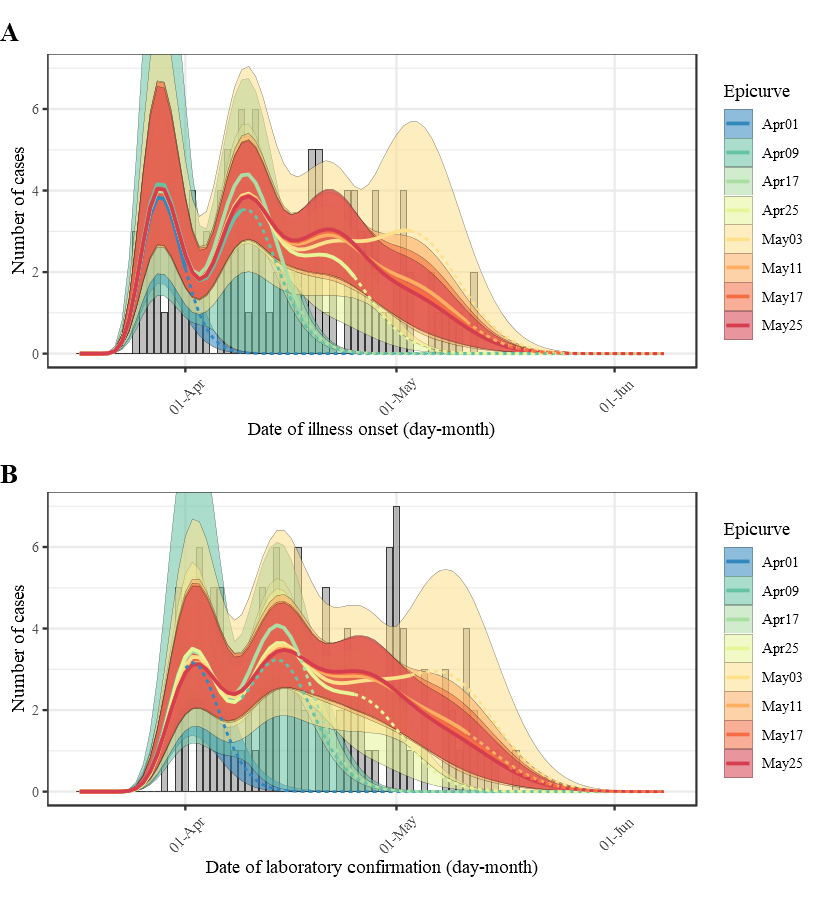

In [49]:
options(repr.plot.width=7,repr.plot.height=7.5)
final_minAIC %<>% mutate(date = as.Date('2018-03-17')+day, epidate = as.Date('2018'%&%epicurve,"%Y%b%d"))

(background_epicurve = rev(all_epicurves)[1])

ymax=7

final_minAIC %>%
    ggplot(aes(x=date,group=epicurve,color=epicurve,fill=epicurve)) +
        geom_bar(data=filter(final_minAIC,epicurve==background_epicurve),
                 aes(y=c),fill="black",color="black",stat="identity",
                 position=position_dodge(1),alpha=.25,size=.15) +
        geom_ribbon(aes(ymin=c025_c,ymax=c975_c),color="black",alpha=.55,size=.05) +
        geom_line(data=final_minAIC %>% filter(date<=epidate),aes(y=MLE_c),size=.8) +
        geom_line(data=final_minAIC %>% filter(date>epidate-1),aes(y=MLE_c),size=.6,linetype="dashed") +
        scale_color_brewer(palette="Spectral",direction=-1) +
        scale_fill_brewer(palette="Spectral",direction=-1) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(x="Date of laboratory confirmation (day-month)",
             y="Number of cases",
             color="Epicurve", 
             fill="Epicurve") +
        coord_cartesian(ylim=c(0,ymax)) +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(.5,1,1,.5),"lines")) -> plt_confirmation

plt_confirmation %<>% arrangeGrob(top = textGrob("B", x = unit(0, "npc"), y = unit(.5, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=16, fontface="bold", fontfamily="Times")))

final_minAIC %>%
    ggplot(aes(x=date,group=epicurve,color=epicurve,fill=epicurve)) +
        geom_bar(data=filter(final_minAIC,epicurve==background_epicurve),
                 aes(y=i),fill="black",color="black",stat="identity",
                 position=position_dodge(1),alpha=.25,size=.15) +
        geom_ribbon(aes(ymin=c025_i,ymax=c975_i),color="black",alpha=.55,size=.05) +
        geom_line(data=final_minAIC %>% filter(date<=epidate),aes(y=MLE_i),size=.8) +
        geom_line(data=final_minAIC %>% filter(date>epidate-1),aes(y=MLE_i),size=.6,linetype="dashed") +
        coord_cartesian(ylim=c(0,ymax)) +
        scale_color_brewer(palette="Spectral",direction=-1) +
        scale_fill_brewer(palette="Spectral",direction=-1) +
        labs(x="Date of illness onset (day-month)",
             y="Number of cases",
             color="Epicurve", 
             fill="Epicurve") +
        scale_x_date(labels = date_format("%d-%b")) +
        theme(
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(1,1,.5,.5),"lines")) -> plt_onset

plt_onset %<>% arrangeGrob(top = textGrob("A", x = unit(0, "npc"), y = unit(.25, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=16, fontface="bold", fontfamily="Times")))

grid.arrange(plt_onset, plt_confirmation, widths=c(1), heights=c(1,1), nrow=2, ncol=1)

# Creating a small animation

Warning message:
"Unknown or uninitialised column: 'date'."Warning message in max(.$date):
"no non-missing arguments to max; returning -Inf"Warning message:
"Removed 14 rows containing missing values (geom_bar)."Warning message:
"Removed 60 rows containing missing values (geom_bar)."

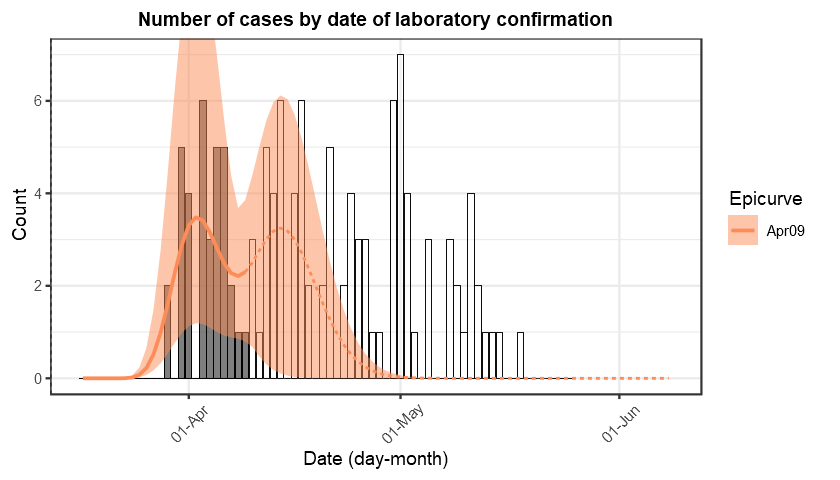

In [50]:
options(repr.plot.width=7,repr.plot.height=4)

current_epicurve = "Apr09"

final_minAIC %>%
    ggplot(aes(x=date,group=epicurve,color=epicurve,fill=epicurve)) +
        geom_bar(data=filter(final_minAIC,epicurve==background_epicurve),
                 aes(y=c),fill="white",color="black",stat="identity",
                 position=position_dodge(1),alpha=.25,size=.2) +
        geom_bar(data=filter(final_minAIC,epicurve==current_epicurve),
                 aes(y=c),fill="black",color="black",stat="identity",
                 position=position_dodge(1),alpha=.5,size=.15) +
        geom_ribbon(data=filter(final_minAIC,epicurve==current_epicurve),
                    aes(ymin=c025_c,ymax=c975_c),alpha=.5,size=0) +
        geom_line(data=filter(final_minAIC,epicurve==current_epicurve & date<=epidate),aes(y=MLE_c),size=.8) +
        geom_line(data=filter(final_minAIC,epicurve==current_epicurve & date>epidate-1),aes(y=MLE_c),size=.6,linetype="dashed") +
        geom_vline(xintercept=filter(final,epicurve==background_epicurve) %>% na.omit %>% { max(.$date) },
                   size=.45, linetype="dashed") +
        scale_color_brewer(palette="Spectral",direction=-1) +
        scale_fill_brewer(palette="Spectral",direction=-1) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(y="Count", x="Date (day-month)",
             title="Number of cases by date of laboratory confirmation",
             color="Epicurve", fill="Epicurve") +
        coord_cartesian(ylim=c(0,ymax)) +
        theme_bw() + 
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(.5,1,.5,.5),"lines"))

In [51]:
options(repr.plot.width=8,repr.plot.height=4)

p = final_minAIC %>%
    ggplot(aes(x=date,group=epicurve,color=epicurve,fill=epicurve)) +
        geom_bar(aes(y=c),fill="black",color="black",stat="identity",
                 position=position_dodge(1),alpha=.5,size=.15) +
        geom_ribbon(data=filter(final_minAIC,epicurve==epicurve),
                    aes(ymin=c025_c,ymax=c975_c),alpha=.5,size=0) +
        geom_line(data=filter(final_minAIC,date<=epidate),aes(y=MLE_c),size=.8) +
        geom_line(data=filter(final_minAIC,date>epidate-1),aes(y=MLE_c),size=.6,linetype="dashed") +
        geom_vline(xintercept=filter(final,epicurve==background_epicurve) %>% na.omit %>% { max(.$date) },
                   size=.45, linetype="dashed") +
        scale_color_brewer(palette="Spectral",direction=-1) +
        scale_fill_brewer(palette="Spectral",direction=-1) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(y="Count", x="Date (day-month)",
             title="Number of cases by date of laboratory confirmation",
             color="Epicurve", fill="Epicurve") +
        coord_cartesian(ylim=c(0,ymax)) +
        theme_bw() + 
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(.5,1,.5,.5),"lines")) +
    transition_manual(epicurve)

animate(p, nframes=length(unique(final_minAIC$epicurve)), fps=2, width=650, height=450, res=100)

Warning message:
"Unknown or uninitialised column: 'date'."Warning message in max(.$date):
"no non-missing arguments to max; returning -Inf"Warning message:
"Removed 68 rows containing missing values (geom_bar)."Warning message:
Rendering [=====>----------------------------------------] at 4 fps ~ eta:  2sWarning message:
Rendering [==========>---------------------------------] at 3.7 fps ~ eta:  2sWarning message:
Rendering [===============>----------------------------] at 3.6 fps ~ eta:  1sWarning message:
Rendering [=====================>----------------------] at 3.7 fps ~ eta:  1sWarning message:
Rendering [===========================>----------------] at 3.7 fps ~ eta:  1sWarning message:
Rendering [================================>-----------] at 3.6 fps ~ eta:  1sWarning message:
Rendering [=====================================>------] at 3.6 fps ~ eta:  0sWarning message:


<img src="data:image/gif;base64,R0lGODlhigLCAfeRAAAAADoAADo6AAAAOjoAOgA6OjMzM2YAAGY6AGYAOmY6OmZmOgAAZjoA
ZgA6Zjo6ZmYAZhlEX01NTW5NTU1Nbm5NbmZmZm5ubnV1dX9/f5A6AJA6OrZmAJBmOrZmOpA6
ZtU+T45NTY5uTatuTY5NbpBmZqtubvRtQ5CQOraQOtuQOquOTZCQZquObraQZpC2Zqurbra2
ZsiOTciObtuQZtu2ZuSrbv2uYf+2ZgA6kDo6kGY6kDpmkABmtjpmtk1Njm5Njk1ujlN/mW5u
jk1uq25uq2Zmto5NjpBmkKtujo5uqzqQkDKIvTqQtliEnmaQkGa2kGaQtm6rq2a2tmbCpTqQ
202OyGaQ22a2226r5Ga2/5C2kMirjtu2kOSrjv+2kMiOq+qep/m2obbbkJDbtqvdpLb/tsjI
jv/Ijv/bkP7gi+b1mP7WsP/bttv/tuTkq//kq///to6OyI651JC226uryJjD3pDb27Lg0rb/
247I/5Db/7bb/6vk5Kvk/7b////b29Xu0dv/2/7vxf/kyPL6y///yP//29vb/8j/5Mj//9v/
/+Tk5Ovr6///5OTk/+T//////wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACH5BAQyAAAAIf8LTkVUU0NBUEUyLjADAQAAACwA
AAAAigLCAQAI/gAjCRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJ
kyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarV
q1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/HOAcAVBmYJgCD
PxUBHxbZBgEAAFpgKkZMcTLJxo8jC7R8kDNVzACmHFj8dzRlv6htAgYwYI/AwqQnev7I4TFk
yaYT50YIyINmi7UzD5xNkDjG3r9nBg+9OyPySMZTS3e5GkCP14ZPS4y+sXZy6s23/ocneEjD
7YveC3LnTrH8eZrpPbr/Pr0+btuRYf+xPBkHAAcd/PcHDQEMEJliLwTwHx8CHeKCggNgsdkB
A1hgGIMEEchaFIu491gOi5AX4H+uRfKFAI85UGINCi7Y4IOsSSgQiyliONxoCS5YXmuRqGBd
QYcEOAAUuZ2Y4h4eAgCigxDKaJCGA3CYJIg3LmYkidDhqKADNkLJYZYVXnililOG6GWIgIU5
QIGu+XidiEcOdGaWDIzhGJnmfeiGaWlayIAL/wXowIAFajYmknkquSdpcypmJ5b2RapRmltk
px9/pvlnGwAF2AZidbYtttxjg4EaWySjWlfmQEkCcFhh/pu+2uJjom4qWCSwhqodqLT+4eNg
PibXqqt/5EprHomCmOpgBaXaw6oTyhrrfoFNi6qt15k6xqyuIuvpIs5mGSoKtwZLXqLEXrtp
ttV6Kkiyi1Ibagy2dvrhIsZ2C29u4fKqZIiSBqxba7VVcWlu/bnKh6ZaHHxrGoE1HACXkbTB
Z2DMElTYAHTgqmBk8RF24SEFa0zhHv5RKTLFFh+WMsAGrTYYxJAVpuypG7tGQ7qEnTyfxyyH
t3HHsIL8XrTaQdyazLhGPLTHkDFdkNKI3vZ00VLbDC7OIxd89cdM+1frgRffGonYC2emn8mt
/TzZ11FjfDbPAtcNUZp7UJod/qYu/3vwYZwVrOmmS59skH9vXjtYyAK5adAhXZQAYd6OcRoF
InPbunTlBVyu3m4F73iHBioLhDjSkUAuOWtVRza4bTwOdLpAJTNOJ2KqTx64YLMrjjerkU/+
c+8F/566BgOMXnqPPxJEvGC/W5beZMa//DfuwbPudqbN+244e3aH/zmP/hWwN8Lcg6g19aDz
bmtmxjvffe1HM584dg7QEa9AXXSAYmuvww///Me64rQPWABYwgEyZrrmvW1i+jPN8N53tOct
rn4PzF+8dlcFCxqvMBqUoHlcNz/oGa5xCVxgQRwnv8QVD31ju131/BaAT5kGhBE8zPb65kIT
LgZ8/uIL4u88BLjASMhHfVNfDRfBPgA0YREWq9mFxlcijRWIaGy61ndg45oUWMdxNaDb8aTI
ABs9boQGdCIUI+Yx820xi0j01Y/CGEPYmHFqV/QYj2w3GTASazVPjKLEOKbHvJ3Qj3XMY87i
Vxg34pEBXbTO1wr3Q37dhn2xs94S+zjHdE3vhopkE9+0E8RSGjB2sNIhuoilSRsW0VZUSpUN
Y9csbNGufq1qjY8IhzLNuUaWiwggLcW1KSq551RjnNYuYffLewGzluu65Xc4yUt/xdKWxlvm
Y/boTGyecIzIzGUzozlKLcrwhK1komm0WcDg5GB//YIhKU1pyvjVZjFp/nDMkNKHr01ejAE5
oljqPNAiHqDpm+SBUZQAZrvUjUhFA2XNFcxVAxRB6hAEfYxBZ2RRiBoQoFuykY+W1yAhEUmH
HpCoub6goCVlFAAbBZJCv2TOj/4BoyqNG0hdlLqZHjR2OB3ARG/D0n8xaUM/rSLzSOrQOPUU
Ql8q5yeLmEkauvKmKRXqSlu6v6Mu9HZgpadYA+YfBualrGNNq1qb8rO9tHWtcI1rUHwkVL7Q
9Qpyzate98rXvvr1r4ANrGAHS9jCGvawiE2sYhfL2MY69rGQ3YsBJkvZylr2spjNrGY3y9nO
evazoA2taEdL2tKa9rSoTa1qV8va1rr2tagV/qwBztKIvtY2sLfdyWwDu9uy5Favv/VrcHHS
278WdyzDjWty97rcmhy3r88NS3PVOl25Vlcm0d1rdr9yXbF2d63ffcl28zreroS3lOcda3pZ
Ut64tncr6w1ffE0535S8d633zUp9BbZf8fXXJPlNa4Cv8t9IFbhuBx7JgMW64KokeDoPllSE
QdJgU1Z4KhNGTYbrs+GOXDiIH45Kh/ky4tSUWCMhDl+Kn3LivLS4Ly++yIrrNuOmxNguN9ZL
jilS44D1eCk7nkuQ7zLkiPw4UgZohJKXzOQmO/nJUI6ylKdM5Spb+cpYzrKWt8zlLnv5y2AO
s5jHTOYym7nLR7ZP/pqRUmS4tJkub3bImqczZ6PEuS13jkueF1Ln1PSZKHtWS6DdMmiE/Nkv
hxZKoWkr2EUbJNF8gTRQHO3bRvdE0nrBtE8oTRZOo8XTAtE0XkTNE1BL19I8IbVdVK0TU4PF
1Z2+tGwZzVdYI1fWvKU1c1Gt21mbxdbm5bVOWE0XYuME2FxB9qtxDVhj30TZWoG2V0zt7LhU
uybSxkq2k81s4+oauMLOybXfMu6ZbNsq5452t/1abpmkmyrv1va6ofvtvMabwPPma7tjcm8R
h5u4vq50rf99k32vxeAv6TdUFA7vfGu33tYluE0QnhaKt4ThTsG4VKgd8FgPHLcO16vF/lmi
caaUfOEhJy/ElStx53b81h8HLMdz/WvbtpwmIzdLzlVycqX0POMpl+vOU/JzNt98JkMfS9JP
UvSjNB3IQXfvyuH6dJ9HHa5LN0

  format width height colorspace matte filesize density
1    gif   650    450       sRGB FALSE        0   39x39
2    gif   650    450       sRGB  TRUE        0   39x39
3    gif   650    450       sRGB  TRUE        0   39x39
4    gif   650    450       sRGB  TRUE        0   39x39
5    gif   650    450       sRGB  TRUE        0   39x39
6    gif   650    450       sRGB  TRUE        0   39x39
7    gif   650    450       sRGB  TRUE        0   39x39
8    gif   650    450       sRGB  TRUE        0   39x39

# Creating a longer animation

## Two generations

In [52]:
filename = "data2.xlsx"

options(warn=-1)
read_excel(filename, sheet = "raw_onset") %>% ncol -> nclmns
read_excel(filename, sheet = "raw_onset", col_types = rep("date",nclmns)) %>%
    gather(epicurve,onset) %>% 
    mutate(number=1:n()) -> df
if (read_excel(filename, sheet = "raw_confirm") %>% ncol!=nclmns)
    message("Something wrong with number of columns in Excel file!")
read_excel(filename, sheet = "raw_confirm", col_types = rep("date",nclmns)) %>%
    gather(epicurve,confirmed) %>%
    mutate(number=1:n()) %>%
    left_join(df) %>%
    select(epicurve,onset,confirmed) %>%
    mutate(onset=as.Date(onset), confirmed=as.Date(confirmed)) -> df
options(warn=0)

df %<>% 
    filter(epicurve=="May27") %>% 
    select(-epicurve) %>%
    mutate(difference=confirmed-onset,
           # if the onset date is unknown, it is assummed to be 5 days prior the confirmation
           difference=ifelse(is.na(onset),5,difference), 
           onset=if_else(is.na(as.numeric(onset)),confirmed-difference,onset)) %>%
    na.omit

# we shift the onset data of the index case to the date of first exposure 
df[which(df$onset=='2018-03-14'),'onset'] = as.Date('2018-03-17')

(mindate = min(df$onset))
(maxdate = max(df$confirmed))
df %<>% 
    mutate(day_onset = unclass(onset)-unclass(mindate),
           day_confirmation = unclass(confirmed)-unclass(mindate))

df %>% head

Joining, by = c("epicurve", "number")


[1] "2018-03-17"

[1] "2018-05-18"

onset,confirmed,difference,day_onset,day_confirmation
2018-03-17,2018-03-20,6,0,3
2018-03-27,2018-03-29,2,10,12
2018-03-27,2018-03-29,2,10,12
2018-03-25,2018-03-31,6,8,14
2018-03-25,2018-03-31,6,8,14
2018-03-26,2018-03-31,5,9,14


In [53]:
nsmpl = 1e4

final_two_generations = NULL
pars_final_two_generations = NULL
# initial parameter values used in optim function
pars = c(5,4,30)
options(warn=-1)
for (current_epicurve in seq(as.Date('2018-04-01'),as.Date('2018-05-27'),by='1 day')) {
    current_epicurve = as.Date(current_epicurve)
    message(as.character(current_epicurve))
    
    df %>% filter(confirmed<=current_epicurve) -> df_current

    Df = data.frame(day=0:(unclass(current_epicurve)-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df

    sol = optim(c(pars[1:2],pars[3]+4),calculate_two_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_two_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_two_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","loglk","AIC","rmse_i","rmse_c")

#     print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                                 df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_two_generations) -> pars_final_two_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_two_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                        select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_two_generations) -> final_two_generations},
    error=function(cond){print(cond)})
}
options(warn=0) 

2018-04-01
2018-04-02
2018-04-03
2018-04-04
2018-04-05
2018-04-06
2018-04-07
2018-04-08
2018-04-09
2018-04-10
2018-04-11
2018-04-12
2018-04-13
2018-04-14
2018-04-15
2018-04-16
2018-04-17
2018-04-18
2018-04-19
2018-04-20
2018-04-21
2018-04-22
2018-04-23
2018-04-24
2018-04-25
2018-04-26
2018-04-27
2018-04-28
2018-04-29
2018-04-30
2018-05-01
2018-05-02
2018-05-03
2018-05-04
2018-05-05
2018-05-06
2018-05-07
2018-05-08
2018-05-09
2018-05-10
2018-05-11
2018-05-12
2018-05-13
2018-05-14
2018-05-15
2018-05-16
2018-05-17
2018-05-18
2018-05-19
2018-05-20
2018-05-21
2018-05-22
2018-05-23
2018-05-24
2018-05-25
2018-05-26
2018-05-27


In [54]:
final_three_generations = NULL
pars_final_three_generations = NULL
pars = c(2,4,50,1)
options(warn=-1)
for (current_epicurve in seq(as.Date('2018-04-01'),as.Date('2018-05-27'),by='1 day')) {
    current_epicurve = as.Date(current_epicurve)
    message(as.character(current_epicurve))
    
    df %>% filter(confirmed<=current_epicurve) -> df_current

    Df = data.frame(day=0:(unclass(current_epicurve)-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df
    

    sol = optim(c(pars[1:2],pars[3]+5,pars[4]),calculate_three_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_three_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_three_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","loglk","AIC","rmse_i","rmse_c")

    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                         df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_three_generations) -> pars_final_three_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_three_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                        select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_three_generations) -> final_three_generations},
    error=function(cond){print(cond)})
}
options(warn=0) 

2018-04-01
2018-04-02
2018-04-03
2018-04-04
2018-04-05
2018-04-06
2018-04-07
2018-04-08
2018-04-09
2018-04-10
2018-04-11
2018-04-12
2018-04-13
2018-04-14
2018-04-15
2018-04-16
2018-04-17
2018-04-18
2018-04-19
2018-04-20
2018-04-21
2018-04-22
2018-04-23
2018-04-24
2018-04-25
2018-04-26
2018-04-27
2018-04-28
2018-04-29
2018-04-30
2018-05-01
2018-05-02
2018-05-03
2018-05-04
2018-05-05
2018-05-06
2018-05-07
2018-05-08
2018-05-09
2018-05-10
2018-05-11
2018-05-12
2018-05-13
2018-05-14
2018-05-15
2018-05-16
2018-05-17
2018-05-18
2018-05-19
2018-05-20
2018-05-21
2018-05-22
2018-05-23
2018-05-24
2018-05-25
2018-05-26
2018-05-27


## Four generations

In [55]:
final_four_generations = NULL
pars_final_four_generations = NULL
pars = c(2,4,50,1,.5) # initial parameter values used in optim function
options(warn=-1)
for (current_epicurve in rev(seq(as.Date('2018-04-01'),as.Date('2018-05-27'),by='1 day'))) {
    current_epicurve = as.Date(current_epicurve)
    message(as.character(current_epicurve))
    
    df %>% filter(confirmed<=current_epicurve) -> df_current

    Df = data.frame(day=0:(unclass(current_epicurve)-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df
    

    sol = optim(c(pars[1:2],pars[3]+10,pars[4:5]),calculate_four_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,3),hessian=TRUE)
    pars = sol$par
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_four_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_four_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","R3","loglk","AIC","rmse_i","rmse_c")

#     print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2","R3")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2,
            R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                         df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","R3_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","R3_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_four_generations) -> pars_final_four_generations
        
        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_four_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                            select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_four_generations) -> final_four_generations}, 
    error=function(cond){print(cond)})
}
options(warn=0)

2018-05-27
2018-05-26
2018-05-25
2018-05-24
2018-05-23
2018-05-22
2018-05-21
2018-05-20
2018-05-19
2018-05-18
2018-05-17
2018-05-16
2018-05-15
2018-05-14
2018-05-13
2018-05-12
2018-05-11
2018-05-10
2018-05-09
2018-05-08
2018-05-07
2018-05-06
2018-05-05
2018-05-04
2018-05-03
2018-05-02
2018-05-01
2018-04-30
2018-04-29
2018-04-28
2018-04-27
2018-04-26
2018-04-25
2018-04-24
2018-04-23
2018-04-22
2018-04-21
2018-04-20
2018-04-19
2018-04-18
2018-04-17
2018-04-16
2018-04-15
2018-04-14
2018-04-13
2018-04-12
2018-04-11


<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


2018-04-10
2018-04-09


<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


2018-04-08
2018-04-07
2018-04-06


<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


2018-04-05


<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


2018-04-04
2018-04-03


<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


2018-04-02


<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


2018-04-01


<simpleError in MASS::mvrnorm(n = nsmpl, mu = sol$par, Sigma = solve(-sol$hessian),     tol = 1e-06, empirical = FALSE, EISPACK = FALSE): 'Sigma' is not positive definite>


## Five generations

In [ ]:
final_five_generations = NULL
pars_final_five_generations = NULL
# initial parameter values used in optim function
pars = c(2,4,50,1,.5,.5)
options(warn=-1)
for (current_epicurve in rev(seq(as.Date('2018-04-01'),as.Date('2018-05-27'),by='1 day'))) {
    current_epicurve = as.Date(current_epicurve)
    message(as.character(current_epicurve))
    
    df %>% filter(confirmed<=current_epicurve) -> df_current

    Df = data.frame(day=0:(unclass(current_epicurve)-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df
    

    sol = optim(c(pars[1:2],pars[3]+10,pars[4:6]),calculate_five_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par 
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_five_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_five_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","R3","R4","loglk","AIC","rmse_i","rmse_c")

#     print(output) 
    
    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2","R3","R4")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2,
            R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3,
            R4=filter(df_hess,R4 > quantile(R4, 0.025) & R4 < quantile(R4, 0.975))$R4
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
                 df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","R3_CIlower","R4_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","R3_CIupper","R4_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_five_generations) -> pars_final_five_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_five_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                            select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_five_generations) -> final_five_generations},
    error=function(cond){print(cond)})
}
options(warn=0)

2018-05-27
2018-05-26
2018-05-25
2018-05-24
2018-05-23
2018-05-22
2018-05-21
2018-05-20
2018-05-19
2018-05-18
2018-05-17
2018-05-16
2018-05-15
2018-05-14
2018-05-13
2018-05-12
2018-05-11
2018-05-10
2018-05-09
2018-05-08
2018-05-07
2018-05-06
2018-05-05
2018-05-04
2018-05-03
2018-05-02
2018-05-01


## Six generations

In [ ]:
final_six_generations = NULL
pars_final_six_generations = NULL
pars = c(2,4,50,1,.5,.5,.25)
options(warn=-1)
for (current_epicurve in rev(seq(as.Date('2018-04-01'),as.Date('2018-05-27'),by='1 day'))) {
    current_epicurve = as.Date(current_epicurve)
    message(as.character(current_epicurve))
    
    df %>% filter(confirmed<=current_epicurve) -> df_current

    Df = data.frame(day=0:(unclass(current_epicurve)-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df

    sol = optim(c(pars[1:2],pars[3]+10,pars[4:7]),calculate_six_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,length(pars)),hessian=TRUE)
    pars = sol$par 
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = calculate_six_generations(sol$par,prediction=TRUE) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    calculate_six_generations(sol$par,prediction=TRUE) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    colnames(output) = c("mean_h","var_h","par1_h","par2_h","K","R2","R3","R4","R5","loglk","AIC","rmse_i","rmse_c")

    tryCatch({
        hess_sam = MASS::mvrnorm(n=nsmpl, mu=sol$par, 
                             Sigma=solve(-sol$hessian),
                             tol=1e-06, empirical=FALSE, EISPACK=FALSE)
        hess_sam %>% as.data.frame -> df_hess
        colnames(df_hess) = c("h1","h2","K","R2","R3","R4","R5")

        data.frame(
            h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
            h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
            K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K,
            R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2,
            R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3,
            R4=filter(df_hess,R4 > quantile(R4, 0.025) & R4 < quantile(R4, 0.975))$R4,
            R5=filter(df_hess,R5 > quantile(R5, 0.025) & R5 < quantile(R5, 0.975))$R5
        ) -> df_perturb
        
        df_perturb[df_perturb<0] = 0 # if some parameters from CIs become negative, we truncate them to zero
        
        df_perturb %<>% 
            mutate(mean_h=h2*gamma(1+1/h1),var_h=h2^2*(gamma(1+2/h1)-(gamma(1+1/h1))^2))
        
        output2 = data.frame(t(c(df_perturb %>% summarize_all(min) %>% as.numeric, 
             df_perturb %>% summarize_all(max) %>% as.numeric)))
        colnames(output2) = c("h1_CIlower","h2_CIlower","K_CIlower","R2_CIlower","R3_CIlower","R4_CIlower","R5_CIlower","mean_h_CIlower","var_h_CIlower",
                              "h1_CIupper","h2_CIupper","K_CIupper","R2_CIupper","R3_CIupper","R4_CIupper","R5_CIupper","mean_h_CIupper","var_h_CIupper")
        output %<>% cbind(output2)
        
        df_perturb %<>% select(-mean_h,-var_h)
        
        output %>%
            gather(parameter,estimate) %>%
            mutate(epicurve=current_epicurve) %>%
            rbind(pars_final_six_generations) -> pars_final_six_generations

        res = NULL
        for (i in 1:nrow(df_perturb)) {
            res = rbind(res,
                        calculate_six_generations(as.numeric(df_perturb[i,]),prediction=TRUE) %>% 
                            select(day,contains("lambda")))
        }

        res %>% 
            group_by(day) %>%
            summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
                      c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

        result %>% 
            mutate(epicurve=current_epicurve) %>%
            left_join(Df,by="day") %>%
            left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
            rbind(final_six_generations) -> final_six_generations},
    error=function(cond){print(cond)})
}
options(warn=0)

In [ ]:
rbind(
    final_two_generations %>% mutate(generations=2),
    final_three_generations %>% mutate(generations=3),
    final_four_generations %>% mutate(generations=4),
    final_five_generations %>% mutate(generations=5),
    final_six_generations %>% mutate(generations=6)
) %>%
select(generations,everything()) -> final

final %>% head

In [ ]:
rbind(
    pars_final_two_generations %>% mutate(generations=2),
    pars_final_three_generations %>% mutate(generations=3),
    pars_final_four_generations %>% mutate(generations=4),
    pars_final_five_generations %>% mutate(generations=5),
    pars_final_six_generations %>% mutate(generations=6)
) %>%
select(generations,everything()) -> pars_final

pars_final %<>% 
    spread(parameter,estimate) %>% 
    select(generations,epicurve,mean_h,mean_h_CIlower,mean_h_CIupper,
           var_h,var_h_CIlower,var_h_CIupper,K,K_CIlower,K_CIupper,starts_with("R"),loglk,AIC,rmse_i,rmse_c)

pars_final %>% head

## Selecting the ones with minimal AIC

In [ ]:
pars_final %>%
    group_by(epicurve) %>%
    filter(AIC==min(AIC)) %>%
    ungroup -> pars_final_minAIC

pars_final_minAIC

In [ ]:
pars_final_minAIC %>%
    select(generations,epicurve) %>%
    left_join(final) %>%
    mutate(date=mindate+day) -> final_minAIC

final_minAIC %>% head

In [ ]:
final_minAIC %<>%
    mutate(epinumber = unclass(epicurve)-unclass(min(epicurve)),generations=as.factor(generations))

p = final_minAIC %>%
    ggplot(aes(x=date,color=generations,fill=generations)) +
        geom_bar(aes(y=c),fill="black",color="black",stat="identity",
                 position=position_dodge(1),alpha=.35,size=.15) +
        geom_ribbon(aes(ymin=c025_c,ymax=c975_c),color="black",alpha=.5,size=0) +
        geom_line(data=filter(final_minAIC,date<=epicurve),aes(y=MLE_c),size=1) +
        geom_line(data=filter(final_minAIC,date>epicurve-1),aes(y=MLE_c),size=.6,linetype="dashed") +
        scale_color_brewer(palette="Dark2",direction=-1) +
        scale_fill_brewer(palette="Dark2",direction=-1) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(y="Number of cases", x="Date of laboratory confirmation (day-month)",
             title="Prediction and forecast for\nthe number of confirmed cases",
             color="Number of\ngenerations", fill="Number of\ngenerations") +
        coord_cartesian(ylim=c(0,ymax)) +
        #guides(color=guide_legend(ncol=2),fill=guide_legend(ncol=2))+
        theme_bw() + 
        theme(
              legend.title=element_text(size=9.5), 
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white")) + 
    transition_manual(epinumber)

animate(p, nframes=length(unique(final_minAIC$epicurve)), fps=5, width=600, height=380, res=100);

In [ ]:
options(repr.plot.width=4.5,repr.plot.height=3.5)

final_minAIC %>% 
    select(epicurve,generations) %>% 
    unique %>%
    ggplot(aes(epicurve,generations,color=generations)) +
        geom_point(size=1) +
        scale_color_brewer(palette="Dark2",direction=-1) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(x="Snapshot (day-month)",y="# of generations") +
        guides(color=FALSE) +
        theme(
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"))